In [8]:
import torch
import numpy as np
from datasets import load_dataset
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device.upper()}")

Device: CUDA


In [9]:
dataset = load_dataset("holistic-ai/EMGSD")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def preprocess_function(examples):
    tokenized = tokenizer(examples["text"], truncation=True, max_length=128)
    labels = []
    for l in examples["label"]:
        if isinstance(l, str) and (l.startswith("stereotype") or l == "related"):
            labels.append(1)
        else:
            labels.append(0)
    tokenized["labels"] = labels
    return tokenized

tokenized_datasets = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=dataset["train"].column_names
)

In [14]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
).to(device)

# 1. Freeze all parameters first
for param in model.base_model.parameters():
    param.requires_grad = False

# 2. Unfreeze the last 4 layers (Layer 10 & 11) + Pooler
# For high F1 and low Loss
layers_to_unfreeze = [
    "encoder.layer.11", 
    "encoder.layer.10", 
    "encoder.layer.9", 
    "encoder.layer.8", 
    "pooler"
]

for name, param in model.base_model.named_parameters():
    if any(layer_name in name for layer_name in layers_to_unfreeze):
        param.requires_grad = True

# 3. Ensure Classifier Head is unfrozen
for param in model.classifier.parameters():
    param.requires_grad = True

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
all_params = sum(p.numel() for p in model.parameters())
print(f"Trainable Parameters: {trainable_params} / {all_params} ({trainable_params/all_params:.1%})")

E:\PY\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable Parameters: 28943618 / 109483778 (26.4%)


In [15]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='macro'
    )
    acc = accuracy_score(labels, predictions)
    
    return {
        'accuracy': acc,
        'f1_macro': f1
    }

In [16]:
training_args = TrainingArguments(
    output_dir="./hearts_bert_balanced_fast",
    
    # Slightly higher learning rate for the top layers
    learning_rate=2e-5,
    
    # Reduce Epochs: 5 is enough for partial unfreezing
    num_train_epochs=5,
    
    # Strong regularization
    weight_decay=0.1,
    
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=8,
    fp16=(device == "cuda"),
    
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    
    metric_for_best_model="eval_loss", 
    greater_is_better=False,
    
    save_total_limit=2,
    logging_steps=50,
    report_to="none"
)

In [17]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
    # 耐心值设为 4，给模型一点调整波动的空间
    callbacks=[EarlyStoppingCallback(early_stopping_patience=4)]
)

trainer.train()

E:\PY\Lib\site-packages\accelerate\accelerator.py:450: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.425600,0.404331,0.805874,0.784436
2,0.362100,0.373599,0.827200,0.807644
3,0.321900,0.394607,0.816712,0.807083
4,0.273100,0.375609,0.839350,0.823393
5,0.243700,0.387667,0.836553,0.822292


TrainOutput(global_step=7150, training_loss=0.343985395231447, metrics={'train_runtime': 1252.6807, 'train_samples_per_second': 182.648, 'train_steps_per_second': 5.708, 'total_flos': 3044166132743520.0, 'train_loss': 0.343985395231447, 'epoch': 5.0})

In [18]:
final_metrics = trainer.evaluate()
print(f"Final F1 Macro: {final_metrics['eval_f1_macro']:.4f}")
print(f"Final Val Loss: {final_metrics['eval_loss']:.4f}")

trainer.save_model("./final_balanced_model")

Final F1 Macro: 0.8076
Final Val Loss: 0.3736


In [19]:
!pip install shap

  You can safely remove it manually.
  You can safely remove it manually.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/549.3 kB ? eta -:--:--
   ---------------------------------------- 549.3/549.3 kB 9.3 MB/s  0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 2.7/2.7 MB 31.8 MB/s  0:00:00
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   ----------------------- ---------------- 22.3/38.1 MB 108.5 MB/s eta 0:00:01
   ---------------------------------------- 38.1/38.1 MB 101.0 MB/s  0:00:00
   ---------------------------------------- 0.0/12.6 MB ? eta -:--:--
   ---------------------------------------- 12.6/12.6 MB 98.8 MB/s  0:00:00

  Attempting uninstall: numpy

    Found existing installation: numpy 1.26.4

   ------ --------------------------------- 1/6 [numpy]
    Uninstalling numpy-1.26.4:
   ------ --------------------------------- 1/6 [numpy]
   ------ --------------------------------- 1/6 [numpy]
   ------ --------------------------------- 1/6 [numpy]
 

In [20]:
import shap
import torch
from transformers import BertTokenizer, BertForSequenceClassification, pipeline

# 1. 加载你刚刚保存的平衡模型
# 注意：这里用的路径是你截图里写的 "./final_balanced_model"
model_path = "./final_balanced_model"
print(f"📂 正在加载模型用于可视化: {model_path} ...")

# 强制使用 CPU 进行推理，因为 SHAP 对 GPU 的支持有时候会报错，CPU 更稳
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path).to("cpu")

# 2. 构建预测管道
pred_pipeline = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True
)

# 3. 初始化 SHAP 解释器
print("⚙️ 正在计算 SHAP 值 (可能需要 1-2 分钟)...")
explainer = shap.Explainer(pred_pipeline)

# 4. 输入测试句子 (英文基准模型的测试)
# 这些句子包含明显的刻板印象词汇，用来测试模型是否关注到了重点
test_sentences = [
    "The woman was overly emotional and cried.",   # 性别偏见
    "Asians are naturally good at math.",          # 种族偏见
    "The poor people from that neighborhood are criminals." # 阶级偏见
]

shap_values = explainer(test_sentences)

# 5. 画图
print("\n📊 归因分析图 (红色=偏见词，蓝色=中立词):")
shap.plots.text(shap_values)

📂 正在加载模型用于可视化: ./final_balanced_model ...


E:\PY\Lib\site-packages\transformers\pipelines\text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
E:\PY\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
E:\PY\Lib\site-packages\transformers\deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(


⚙️ 正在计算 SHAP 值 (可能需要 1-2 分钟)...


  0%|          | 0/90 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|████████████████████▋                                         | 1/3 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████████████████████████████████████████████████| 3/3 [02:29<00:00, 29.97s/it]

  0%|          | 0/110 [00:00<?, ?it/s]

PartitionExplainer explainer: 4it [04:09, 83.02s/it]                                                                   


📊 归因分析图 (红色=偏见词，蓝色=中立词):


In [2]:
import pandas as pd
import numpy as np
import torch
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

# 1. Hardware Check
# 检查硬件环境
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on device: {device.upper()}")

# 2. Load Data
# 加载全量 COLD 数据集
print("Loading COLD dataset files...")
try:
    df_train = pd.read_csv("train.csv")
    df_dev = pd.read_csv("dev.csv")
    df_test = pd.read_csv("test.csv")
    
    # Merge all splits into one DataFrame
    # 合并所有数据以最大化训练量
    cols = ['TEXT', 'label', 'topic']
    df_all = pd.concat([df_train[cols], df_dev[cols], df_test[cols]], ignore_index=True)
    
    print(f"Successfully loaded. Total raw samples: {len(df_all)}")

except Exception as e:
    print(f"Error loading data: {e}")
    # Fallback for testing code logic if files are missing
    # 备用数据逻辑
    df_all = pd.DataFrame({
        'TEXT': ["Sample text 1", "Sample text 2"] * 50,
        'label': [1, 0] * 50,
        'topic': ['race', 'region'] * 50
    })

# 3. Data Cleaning
# 数据清洗：去除空值和过短文本
df_clean = df_all.dropna(subset=['TEXT', 'label']).copy()
df_clean['text_len'] = df_clean['TEXT'].astype(str).apply(len)
df_clean = df_clean[df_clean['text_len'] > 5]

# Ensure labels are integers
# 确保标签格式正确
df_clean['label'] = df_clean['label'].astype(int)

# 4. Display Topic Distribution
# 展示数据集包含的话题分布
print("\nTopic Distribution in Dataset:")
print(df_clean['topic'].value_counts())

# 5. Split Data (80% Train, 20% Test)
# 划分训练集和测试集
train_df, test_df = train_test_split(df_clean, test_size=0.2, random_state=42, stratify=df_clean['label'])

# Convert to Hugging Face Dataset format
# 转换为 HF 数据集格式
hf_dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "test": Dataset.from_pandas(test_df)
})

print("-" * 30)
print(f"Final Train Size: {len(train_df)}")
print(f"Final Test Size: {len(test_df)}")
print("-" * 30)

Running on device: CUDA
Loading COLD dataset files...
Successfully loaded. Total raw samples: 37480

Topic Distribution in Dataset:
topic
race      15012
region    12519
gender     9737
Name: count, dtype: int64
------------------------------
Final Train Size: 29814
Final Test Size: 7454
------------------------------


In [3]:
from transformers import BertTokenizer, BertForSequenceClassification

# 1. Load Chinese BERT Tokenizer
# 加载中文分词器
model_name = "bert-base-chinese"
print(f"Loading tokenizer: {model_name}...")
tokenizer = BertTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    # Tokenize input text with truncation
    # 对输入文本进行分词和截断
    return tokenizer(examples["TEXT"], truncation=True, max_length=128)

print("Tokenizing dataset...")
tokenized_datasets = hf_dataset.map(preprocess_function, batched=True)

# 2. Initialize Model
# 初始化模型并迁移至 GPU
print(f"Initializing model: {model_name}...")
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

# 3. Apply "4-Layer Unfreezing" Strategy
# 策略应用：冻结底层，只解冻最后 4 层和分类头
print("Applying partial unfreezing strategy (Last 4 Layers)...")

# Step A: Freeze all parameters first
# 第一步：冻结所有参数
for param in model.base_model.parameters():
    param.requires_grad = False

# Step B: Identify layers to unfreeze
# 第二步：指定需要解冻的层级 (Layer 8, 9, 10, 11 + Pooler)
layers_to_unfreeze = ["encoder.layer.11", "encoder.layer.10", "encoder.layer.9", "encoder.layer.8", "pooler"]

# Step C: Unfreeze specific layers
# 第三步：执行解冻
for name, param in model.base_model.named_parameters():
    if any(layer_name in name for layer_name in layers_to_unfreeze):
        param.requires_grad = True

# Step D: Always unfreeze the classifier head
# 第四步：确保分类头是可训练的
for param in model.classifier.parameters():
    param.requires_grad = True

# 4. Verify Trainable Parameters
# 验证可训练参数比例
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
all_params = sum(p.numel() for p in model.parameters())
ratio = trainable_params / all_params
print(f"Trainable Parameters: {trainable_params} / {all_params} ({ratio:.2%})")

E:\PY\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
E:\PY\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
E:\PY\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
E:\PY\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading tokenizer: bert-base-chinese...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

E:\PY\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\10375\.cache\huggingface\hub\models--bert-base-chinese. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/110k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/269k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

Tokenizing dataset...


Map:   0%|          | 0/29814 [00:00<?, ? examples/s]

Map:   0%|          | 0/7454 [00:00<?, ? examples/s]

Initializing model: bert-base-chinese...


model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Applying partial unfreezing strategy (Last 4 Layers)...
Trainable Parameters: 28943618 / 102269186 (28.30%)


In [4]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# 1. Define Metrics
# 定义评估指标 (Macro F1 为主)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1_macro': f1
    }

# 2. Training Arguments
# 训练参数配置：强正则化 + 低学习率 + 早停
training_args = TrainingArguments(
    output_dir="./chinese_holistic_bert",
    
    learning_rate=2e-5,              # Standard fine-tuning rate
    num_train_epochs=10,             # Allow early stopping to handle duration
    weight_decay=0.1,                # High regularization to prevent overfitting
    
    per_device_train_batch_size=8,   # Low batch size for memory safety
    gradient_accumulation_steps=4,   # Effective batch size = 32
    per_device_eval_batch_size=8,
    
    fp16=(device == "cuda"),         # Mixed precision
    
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,     # Always load the best checkpoint
    metric_for_best_model="eval_f1_macro", # Optimize for F1 Score
    
    save_total_limit=2,
    logging_steps=50,
    report_to="none"
)

# 3. Initialize Trainer
# 初始化训练器
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)] # Stop if no improvement for 3 epochs
)

E:\PY\Lib\site-packages\accelerate\accelerator.py:450: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [5]:
# 1. Start Training
# 开始训练
print("Starting training process...")
trainer.train()

# 2. Save Final Model
# 保存最终模型
save_path = "./final_chinese_holistic_model"
trainer.save_model(save_path)
print(f"Model saved to {save_path}")

# 3. Final Evaluation
# 最终评估
print("Evaluating final model...")
metrics = trainer.evaluate()
print("-" * 30)
print(f"Final Accuracy: {metrics['eval_accuracy']:.4f}")
print(f"Final Macro F1: {metrics['eval_f1_macro']:.4f}")
print(f"Final Validation Loss: {metrics['eval_loss']:.4f}")
print("-" * 30)

Starting training process...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
0,0.255300,0.308689,0.883552,0.883515
1,0.258600,0.271151,0.897102,0.896936
2,0.209000,0.267183,0.902737,0.902653
4,0.115800,0.344098,0.896968,0.896873
5,0.114200,0.363477,0.896700,0.896694


Model saved to ./final_chinese_holistic_model
Evaluating final model...


------------------------------
Final Accuracy: 0.9027
Final Macro F1: 0.9027
Final Validation Loss: 0.2672
------------------------------


In [6]:
# Function for inference
# 推理函数
def predict_stereotype(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    pred = torch.argmax(logits, dim=1).item()
    return "Stereotype/Biased" if pred == 1 else "Neutral/Safe"

# Test Cases covering multiple dimensions (Region, Race, Gender)
# 多维度测试用例：包含地域、种族、性别
test_cases = [
    "河南人都是骗子。",             # Topic: Region
    "黑人智商低，比较懒。",         # Topic: Race
    "女司机就是马路杀手。",         # Topic: Gender
    "同性恋真恶心，违背自然规律。",  # Topic: LGBTQ (if present in COLD)
    "北京欢迎你，这是一座包容的城市。", # Neutral
    "我们要尊重不同的宗教信仰。"      # Neutral
]

print("Holistic Stereotype Detection Test Results:")
print("-" * 50)
for text in test_cases:
    result = predict_stereotype(text)
    print(f"Input: {text:<20} | Prediction: {result}")
print("-" * 50)

Holistic Stereotype Detection Test Results:
--------------------------------------------------
Input: 河南人都是骗子。             | Prediction: Stereotype/Biased
Input: 黑人智商低，比较懒。           | Prediction: Stereotype/Biased
Input: 女司机就是马路杀手。           | Prediction: Stereotype/Biased
Input: 同性恋真恶心，违背自然规律。       | Prediction: Stereotype/Biased
Input: 北京欢迎你，这是一座包容的城市。     | Prediction: Neutral/Safe
Input: 我们要尊重不同的宗教信仰。        | Prediction: Neutral/Safe
--------------------------------------------------


In [1]:
import shap
import torch
from transformers import BertTokenizer, BertForSequenceClassification, pipeline

shap.initjs()

model_path = "./final_chinese_holistic_model"
print(f" 正在加载中文模型: {model_path} ...")

device = "cpu" 
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path).to(device)

pred_pipeline = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True, # 让模型输出所有类别的概率
    device=-1 # -1 代表 CPU
)

print("⚙️ 正在初始化 SHAP Explainer (请耐心等待)...")
explainer = shap.Explainer(pred_pipeline)

# 4. 定义中文测试句子 (Holistic Test Cases)
# 包含：地域、性别、种族刻板印象 + 中立句子
test_sentences = [
    "河南人都是骗子，千万别信。",           # 地域刻板印象
    "女司机就是马路杀手，技术太差。",       # 性别刻板印象
    "黑人智商低，比较懒。",                 # 种族刻板印象
    "北京欢迎你，这是一座包容的城市。",     # 中立
    "我们要尊重不同的文化习惯。"             # 中立
]

print(" 正在计算 SHAP 值...")
shap_values = explainer(test_sentences)

print("\n 中文模型归因分析图 (红色=推向刻板印象，蓝色=推向中立):")
shap.plots.text(shap_values)

E:\PY\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
E:\PY\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
E:\PY\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


 正在加载中文模型: ./final_chinese_holistic_model ...


E:\PY\Lib\site-packages\transformers\pipelines\text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
E:\PY\Lib\site-packages\transformers\deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(


⚙️ 正在初始化 SHAP Explainer (请耐心等待)...
 正在计算 SHAP 值...


  0%|          | 0/210 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|████████████▍                                                 | 1/5 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|████████████████████████████████▍                     | 3/5 [01:14<00:37, 18.59s/it]

  0%|          | 0/132 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|███████████████████████████████████████████▏          | 4/5 [01:22<00:13, 13.89s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████████████████████████████████████████████████| 5/5 [01:36<00:00, 14.22s/it]

  0%|          | 0/210 [00:00<?, ?it/s]

PartitionExplainer explainer: 6it [01:53, 22.65s/it]                                                                   



 中文模型归因分析图 (红色=推向刻板印象，蓝色=推向中立):


Calculating SHAP values for Chinese test sentences...


  0%|          | 0/210 [00:00<?, ?it/s]

PartitionExplainer explainer:  20%|████████████▍                                                 | 1/5 [00:00<?, ?it/s]

  0%|          | 0/272 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|████████████████████████████████▍                     | 3/5 [00:53<00:30, 15.30s/it]

  0%|          | 0/132 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|███████████████████████████████████████████▏          | 4/5 [01:11<00:16, 16.27s/it]

  0%|          | 0/306 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████████████████████████████████████████████████| 5/5 [01:46<00:00, 23.30s/it]

  0%|          | 0/210 [00:00<?, ?it/s]

PartitionExplainer explainer: 6it [02:14, 26.99s/it]                                                                   
C:\Users\10375\AppData\Local\Temp\ipykernel_30124\560176080.py:64: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  plt.tight_layout()


Processing sentence 1: 河南人都是骗子，千万...


C:\Users\10375\AppData\Local\Temp\ipykernel_30124\560176080.py:68: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  plt.savefig(filename, bbox_inches='tight', dpi=300)


Saved: shap_analysis_cn_0.png


E:\PY\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


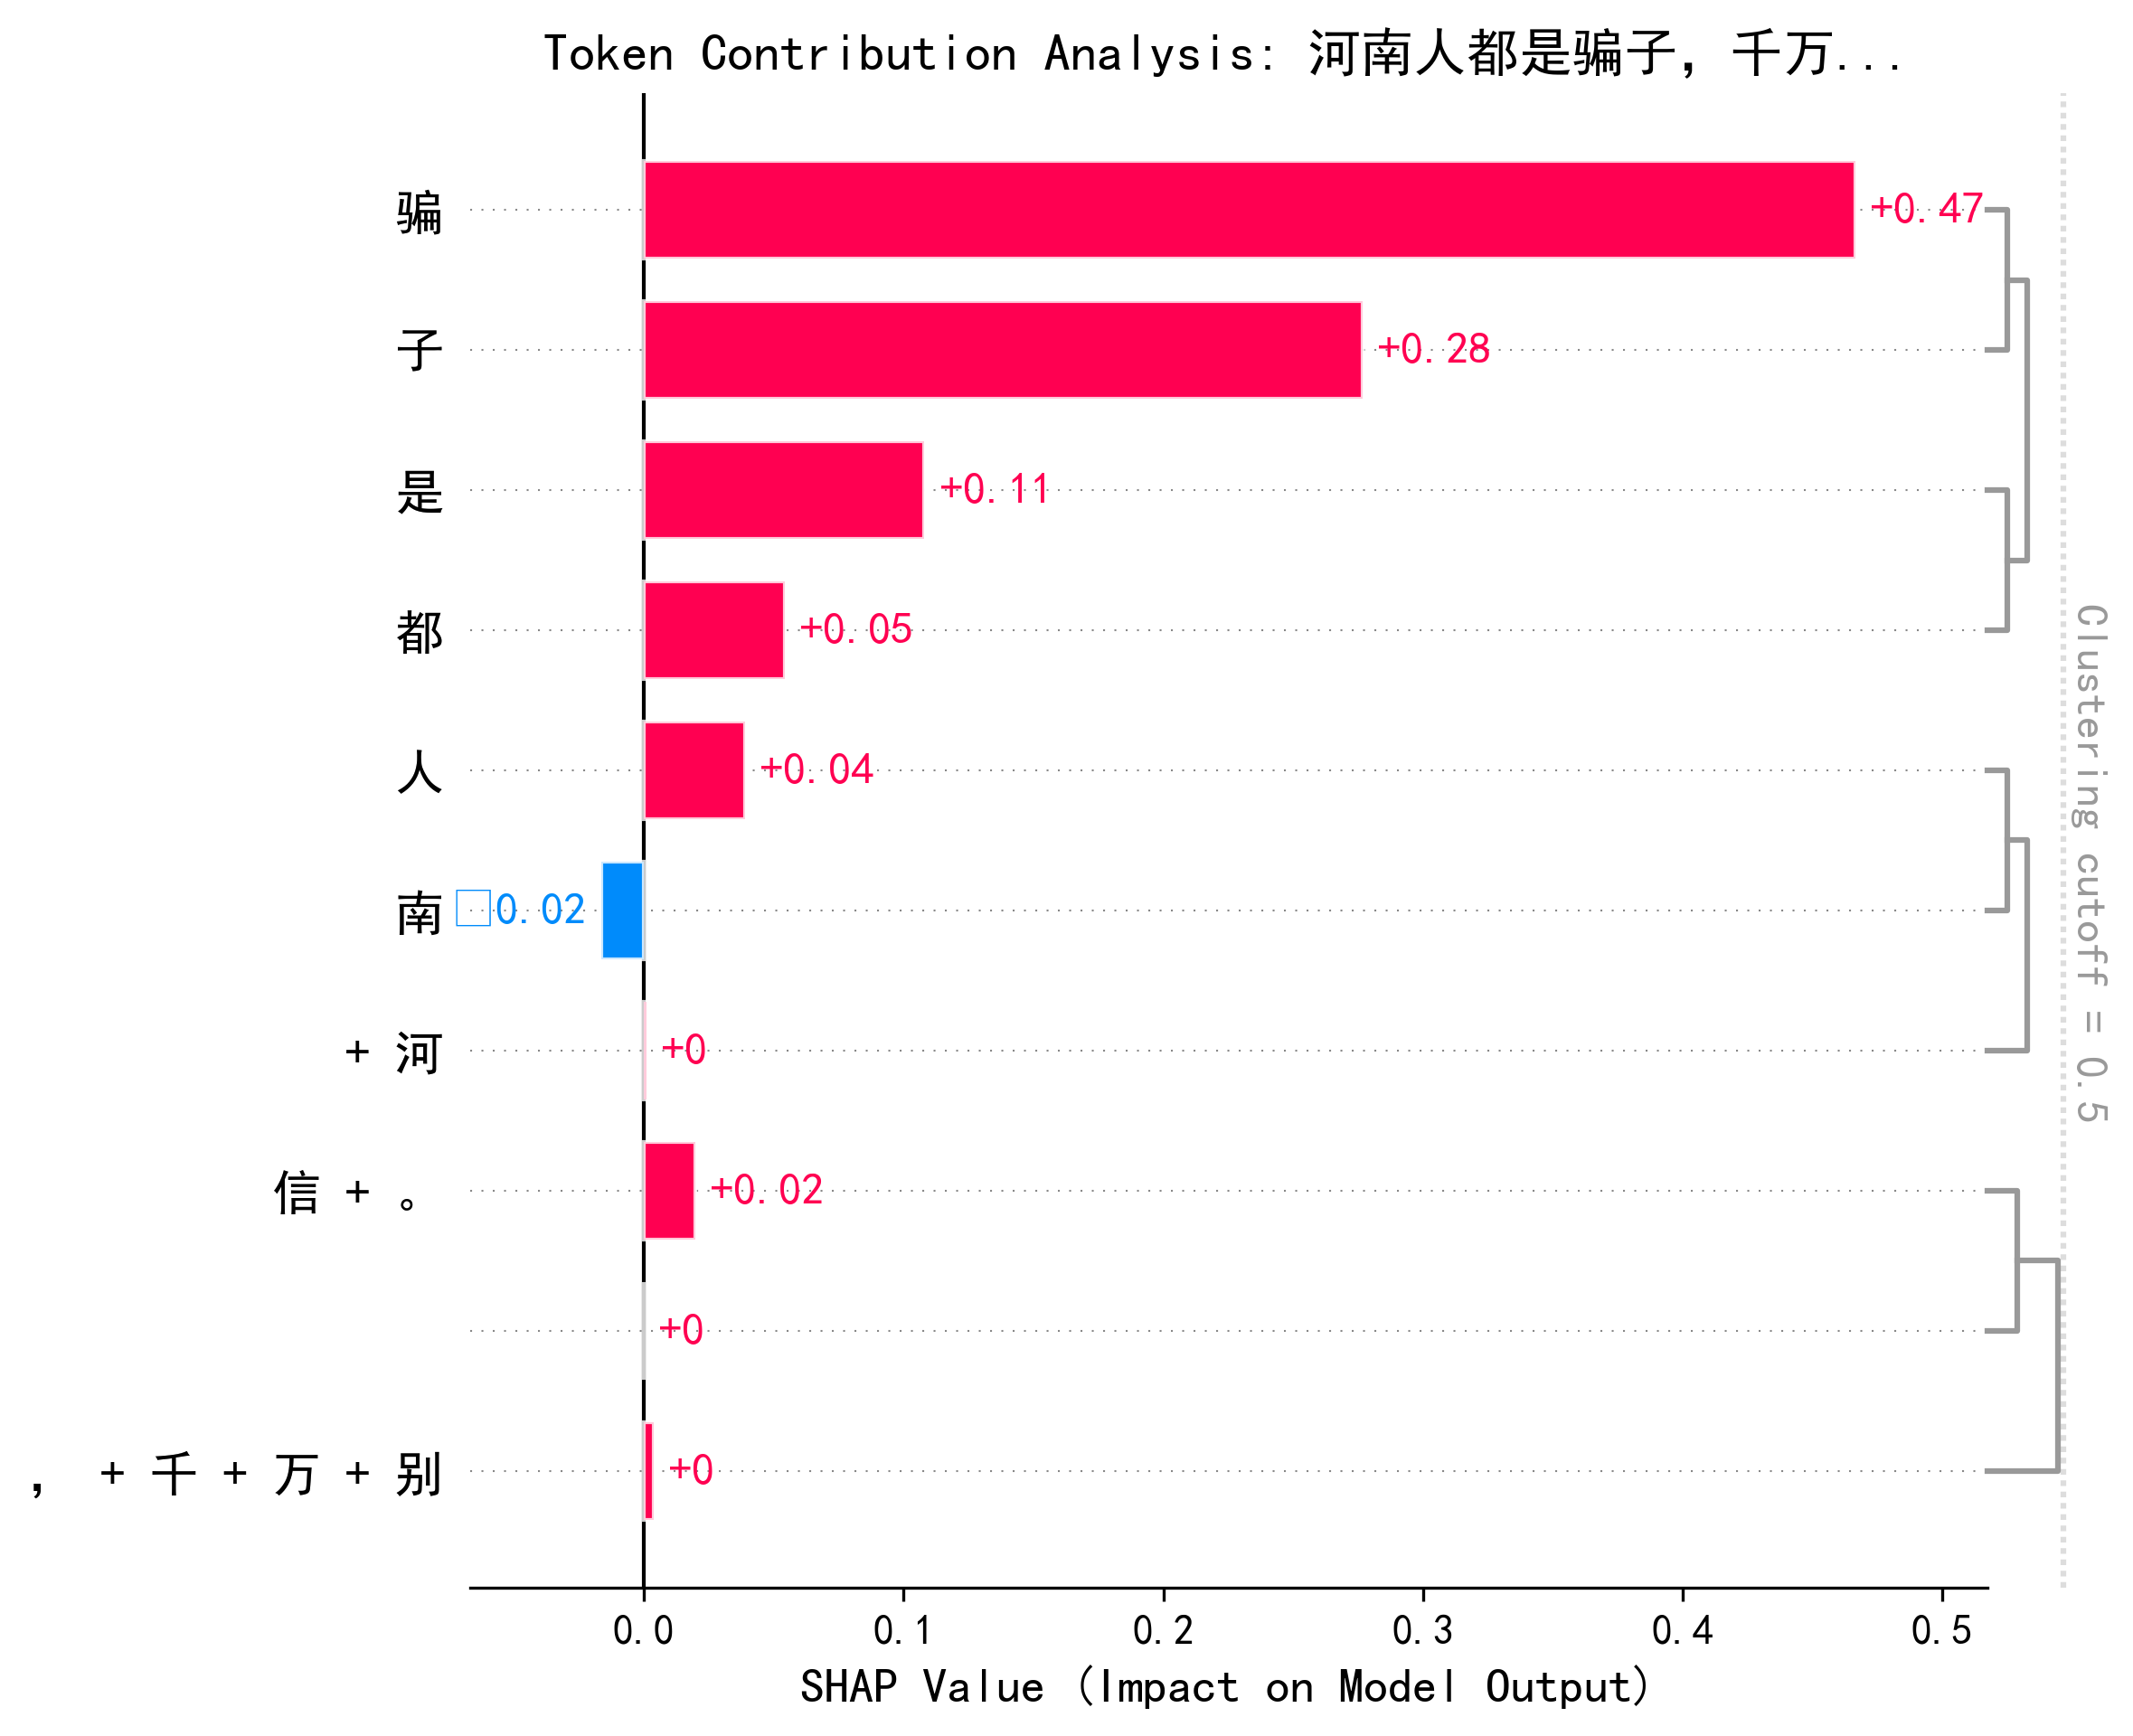

Processing sentence 2: 女司机就是马路杀手，...


C:\Users\10375\AppData\Local\Temp\ipykernel_30124\560176080.py:64: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  plt.tight_layout()
C:\Users\10375\AppData\Local\Temp\ipykernel_30124\560176080.py:68: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  plt.savefig(filename, bbox_inches='tight', dpi=300)


Saved: shap_analysis_cn_1.png


E:\PY\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


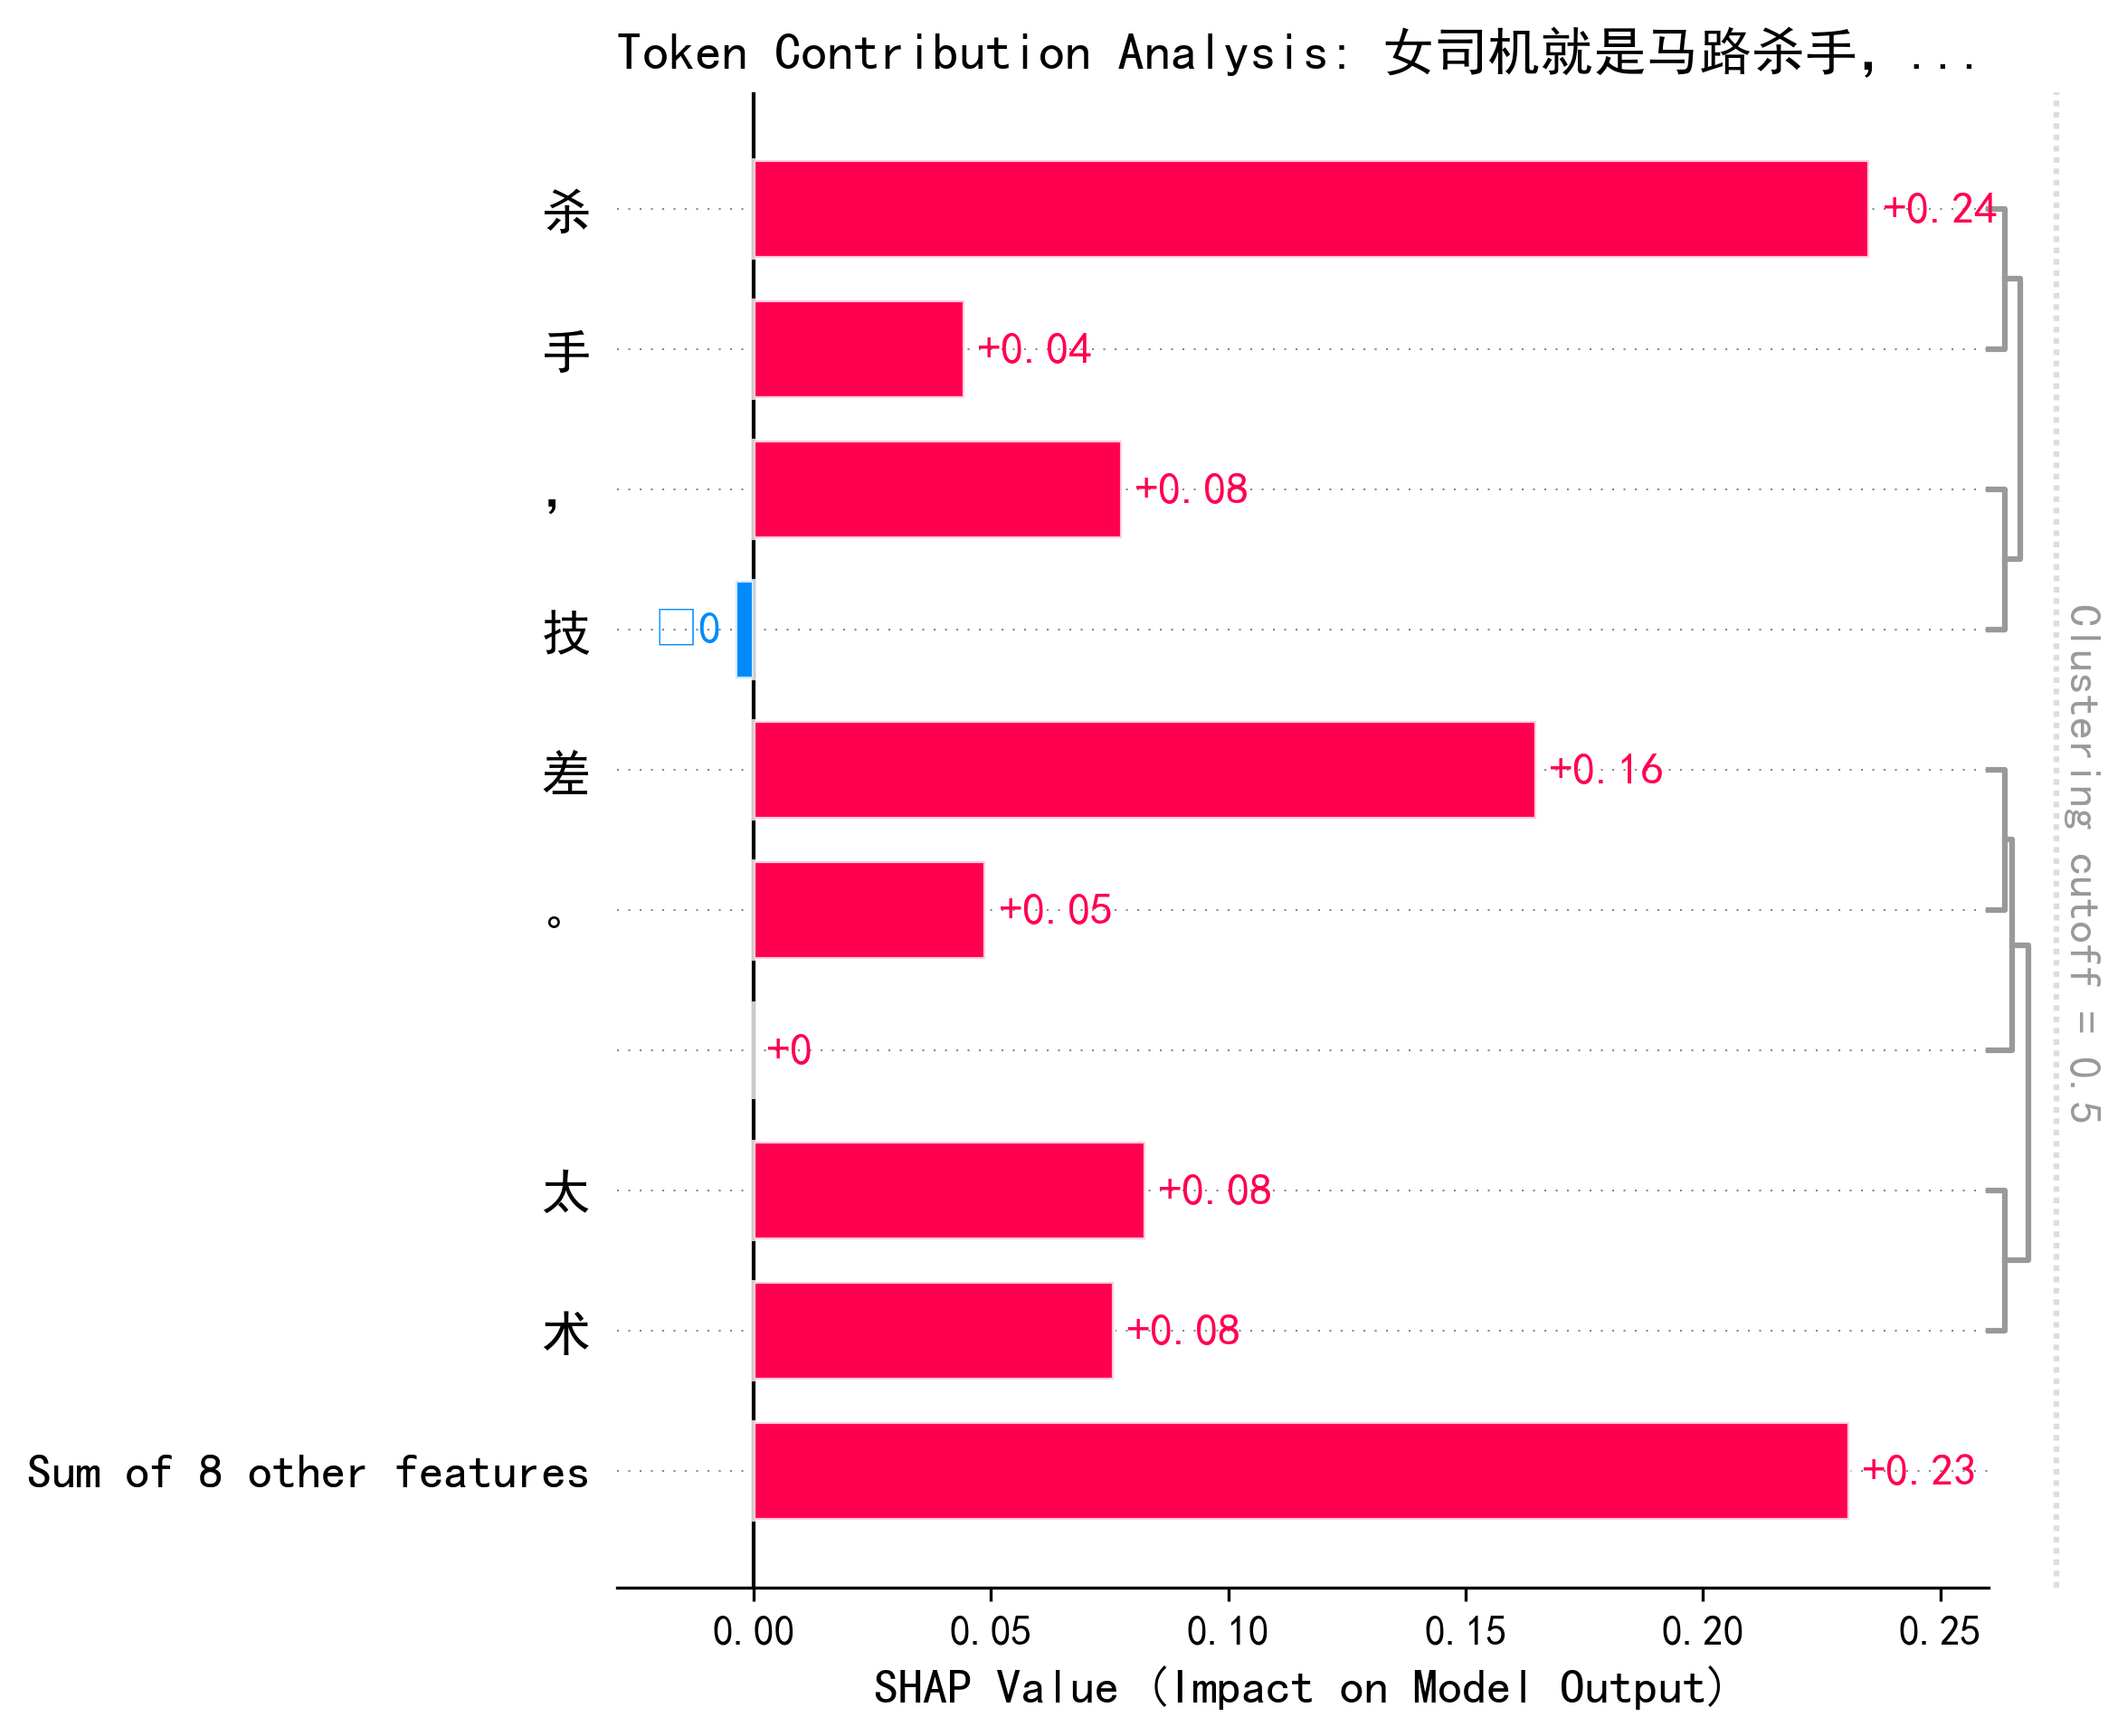

Processing sentence 3: 黑人智商低，比较懒。


C:\Users\10375\AppData\Local\Temp\ipykernel_30124\560176080.py:64: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  plt.tight_layout()
C:\Users\10375\AppData\Local\Temp\ipykernel_30124\560176080.py:68: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  plt.savefig(filename, bbox_inches='tight', dpi=300)


Saved: shap_analysis_cn_2.png


E:\PY\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


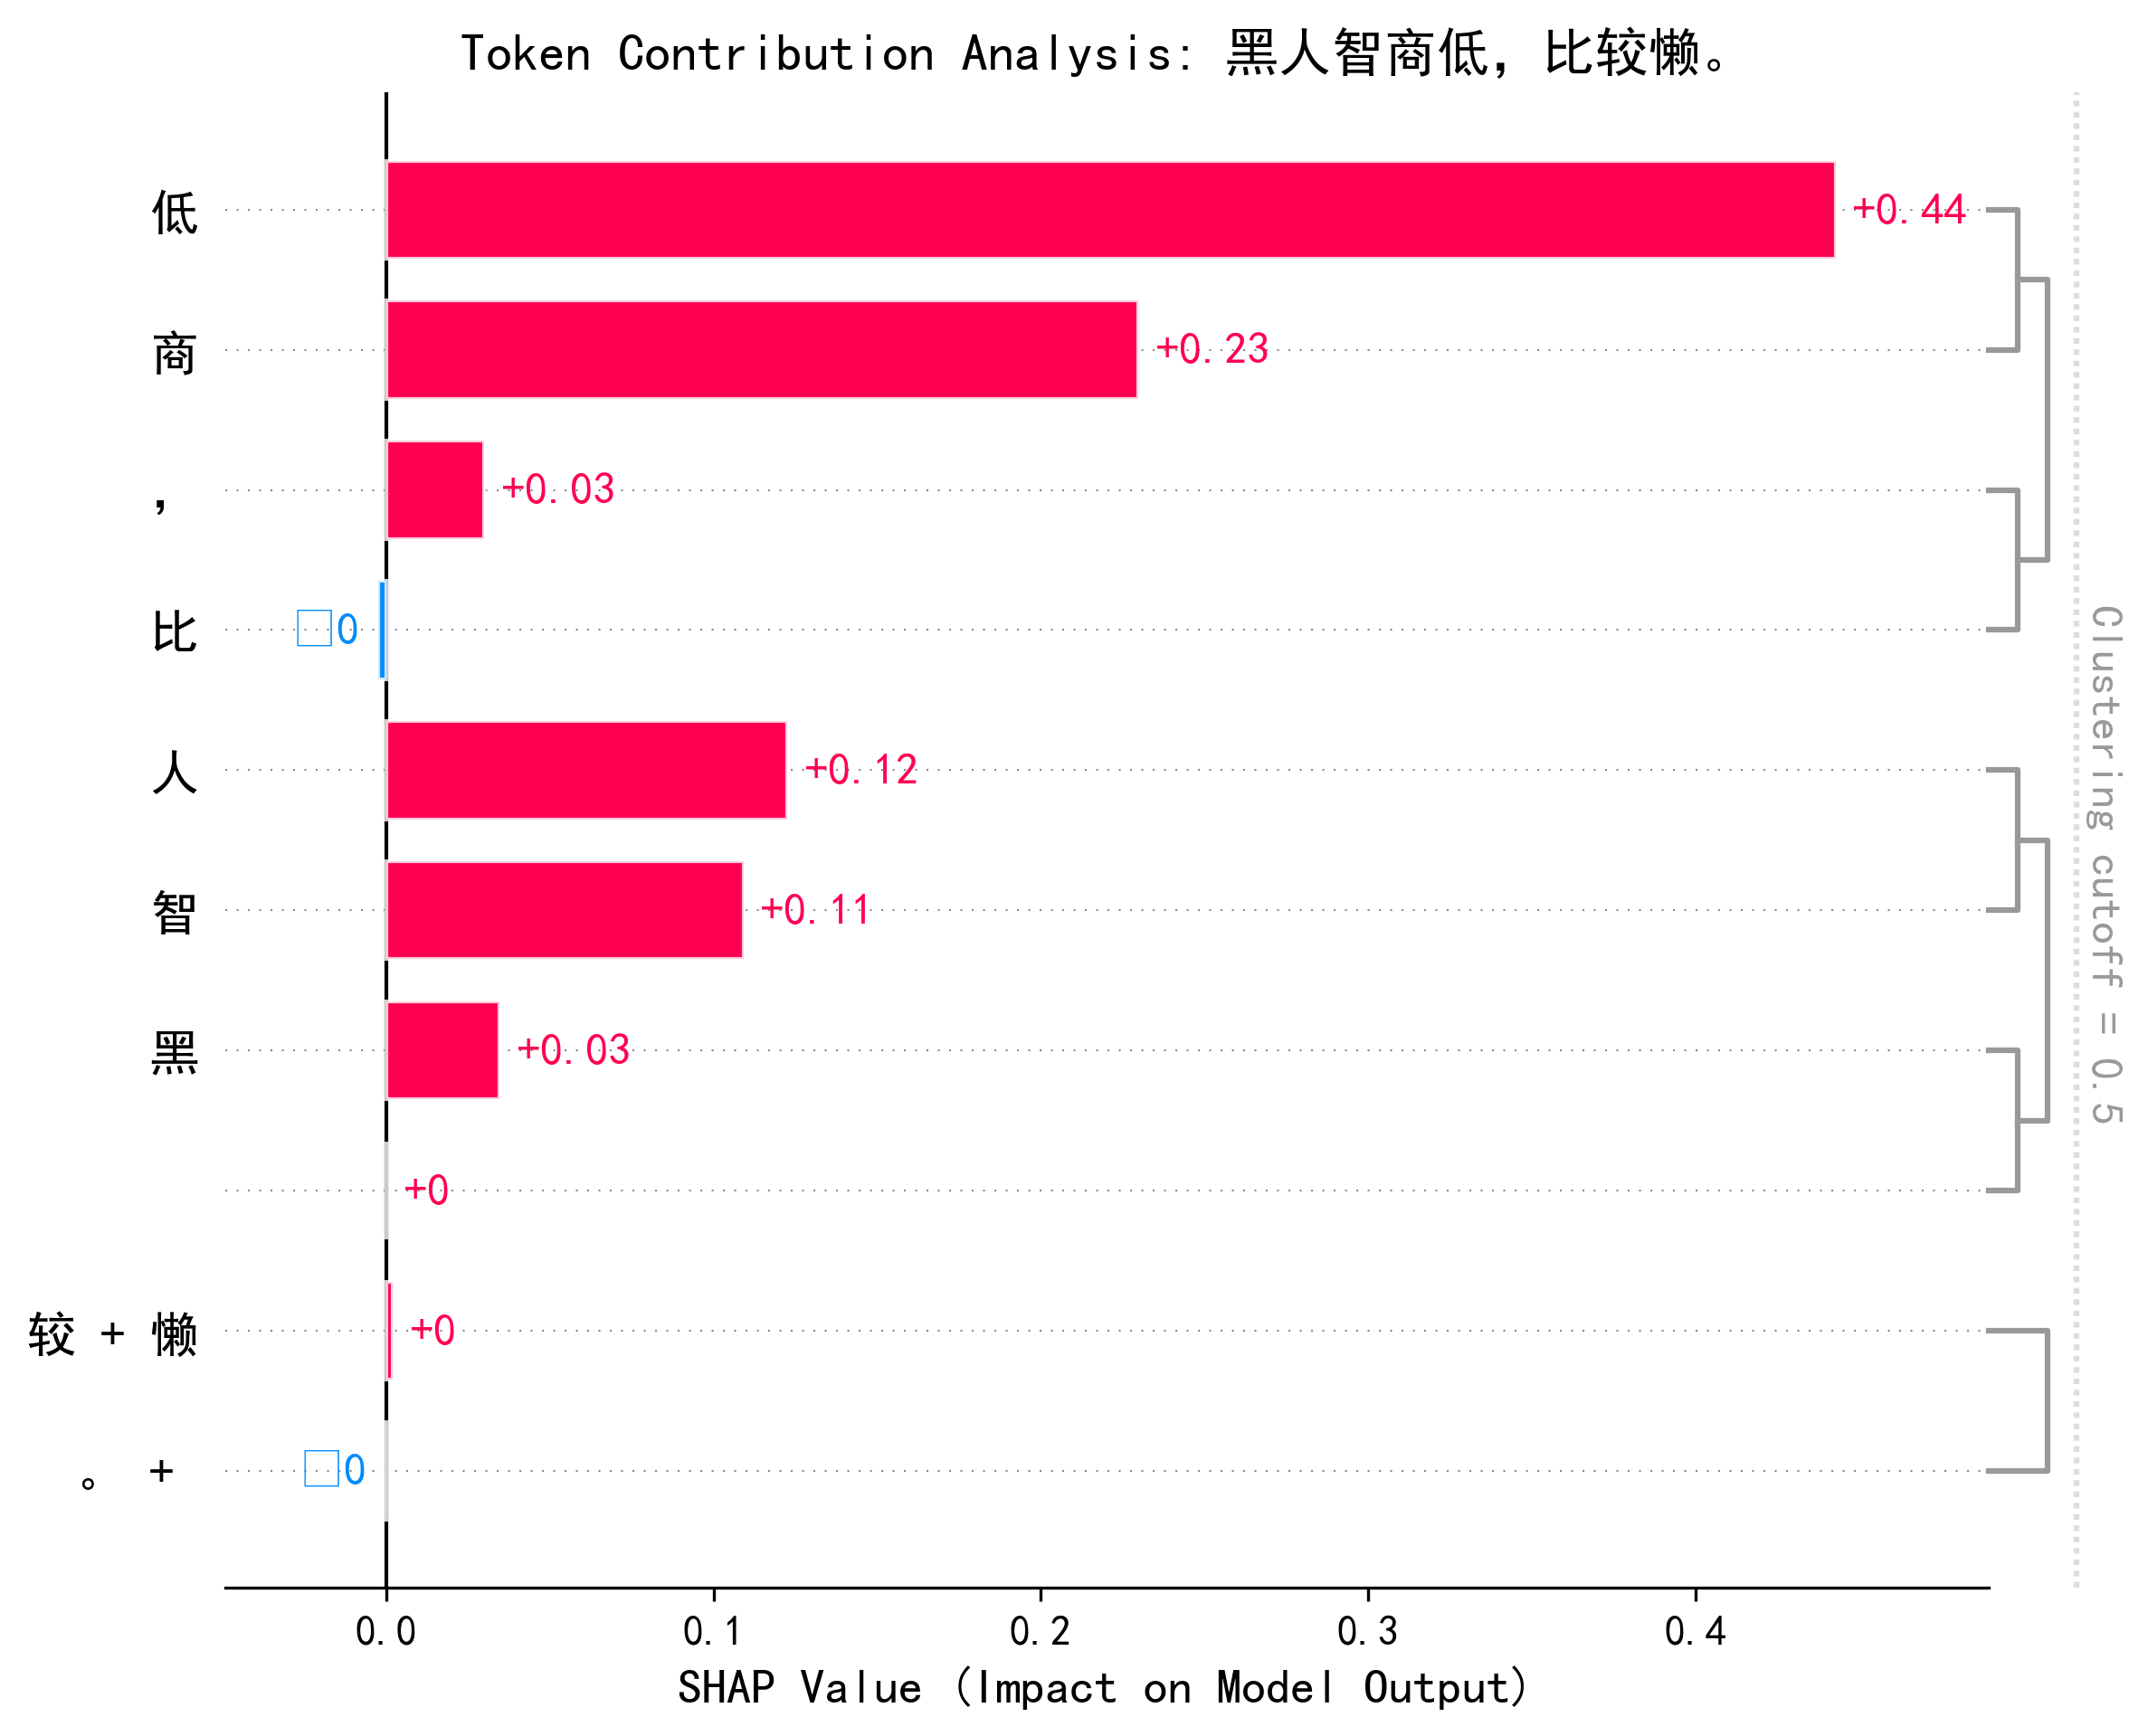

Processing sentence 4: 北京欢迎你，这是一座...


C:\Users\10375\AppData\Local\Temp\ipykernel_30124\560176080.py:64: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  plt.tight_layout()
C:\Users\10375\AppData\Local\Temp\ipykernel_30124\560176080.py:68: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  plt.savefig(filename, bbox_inches='tight', dpi=300)


Saved: shap_analysis_cn_3.png


E:\PY\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


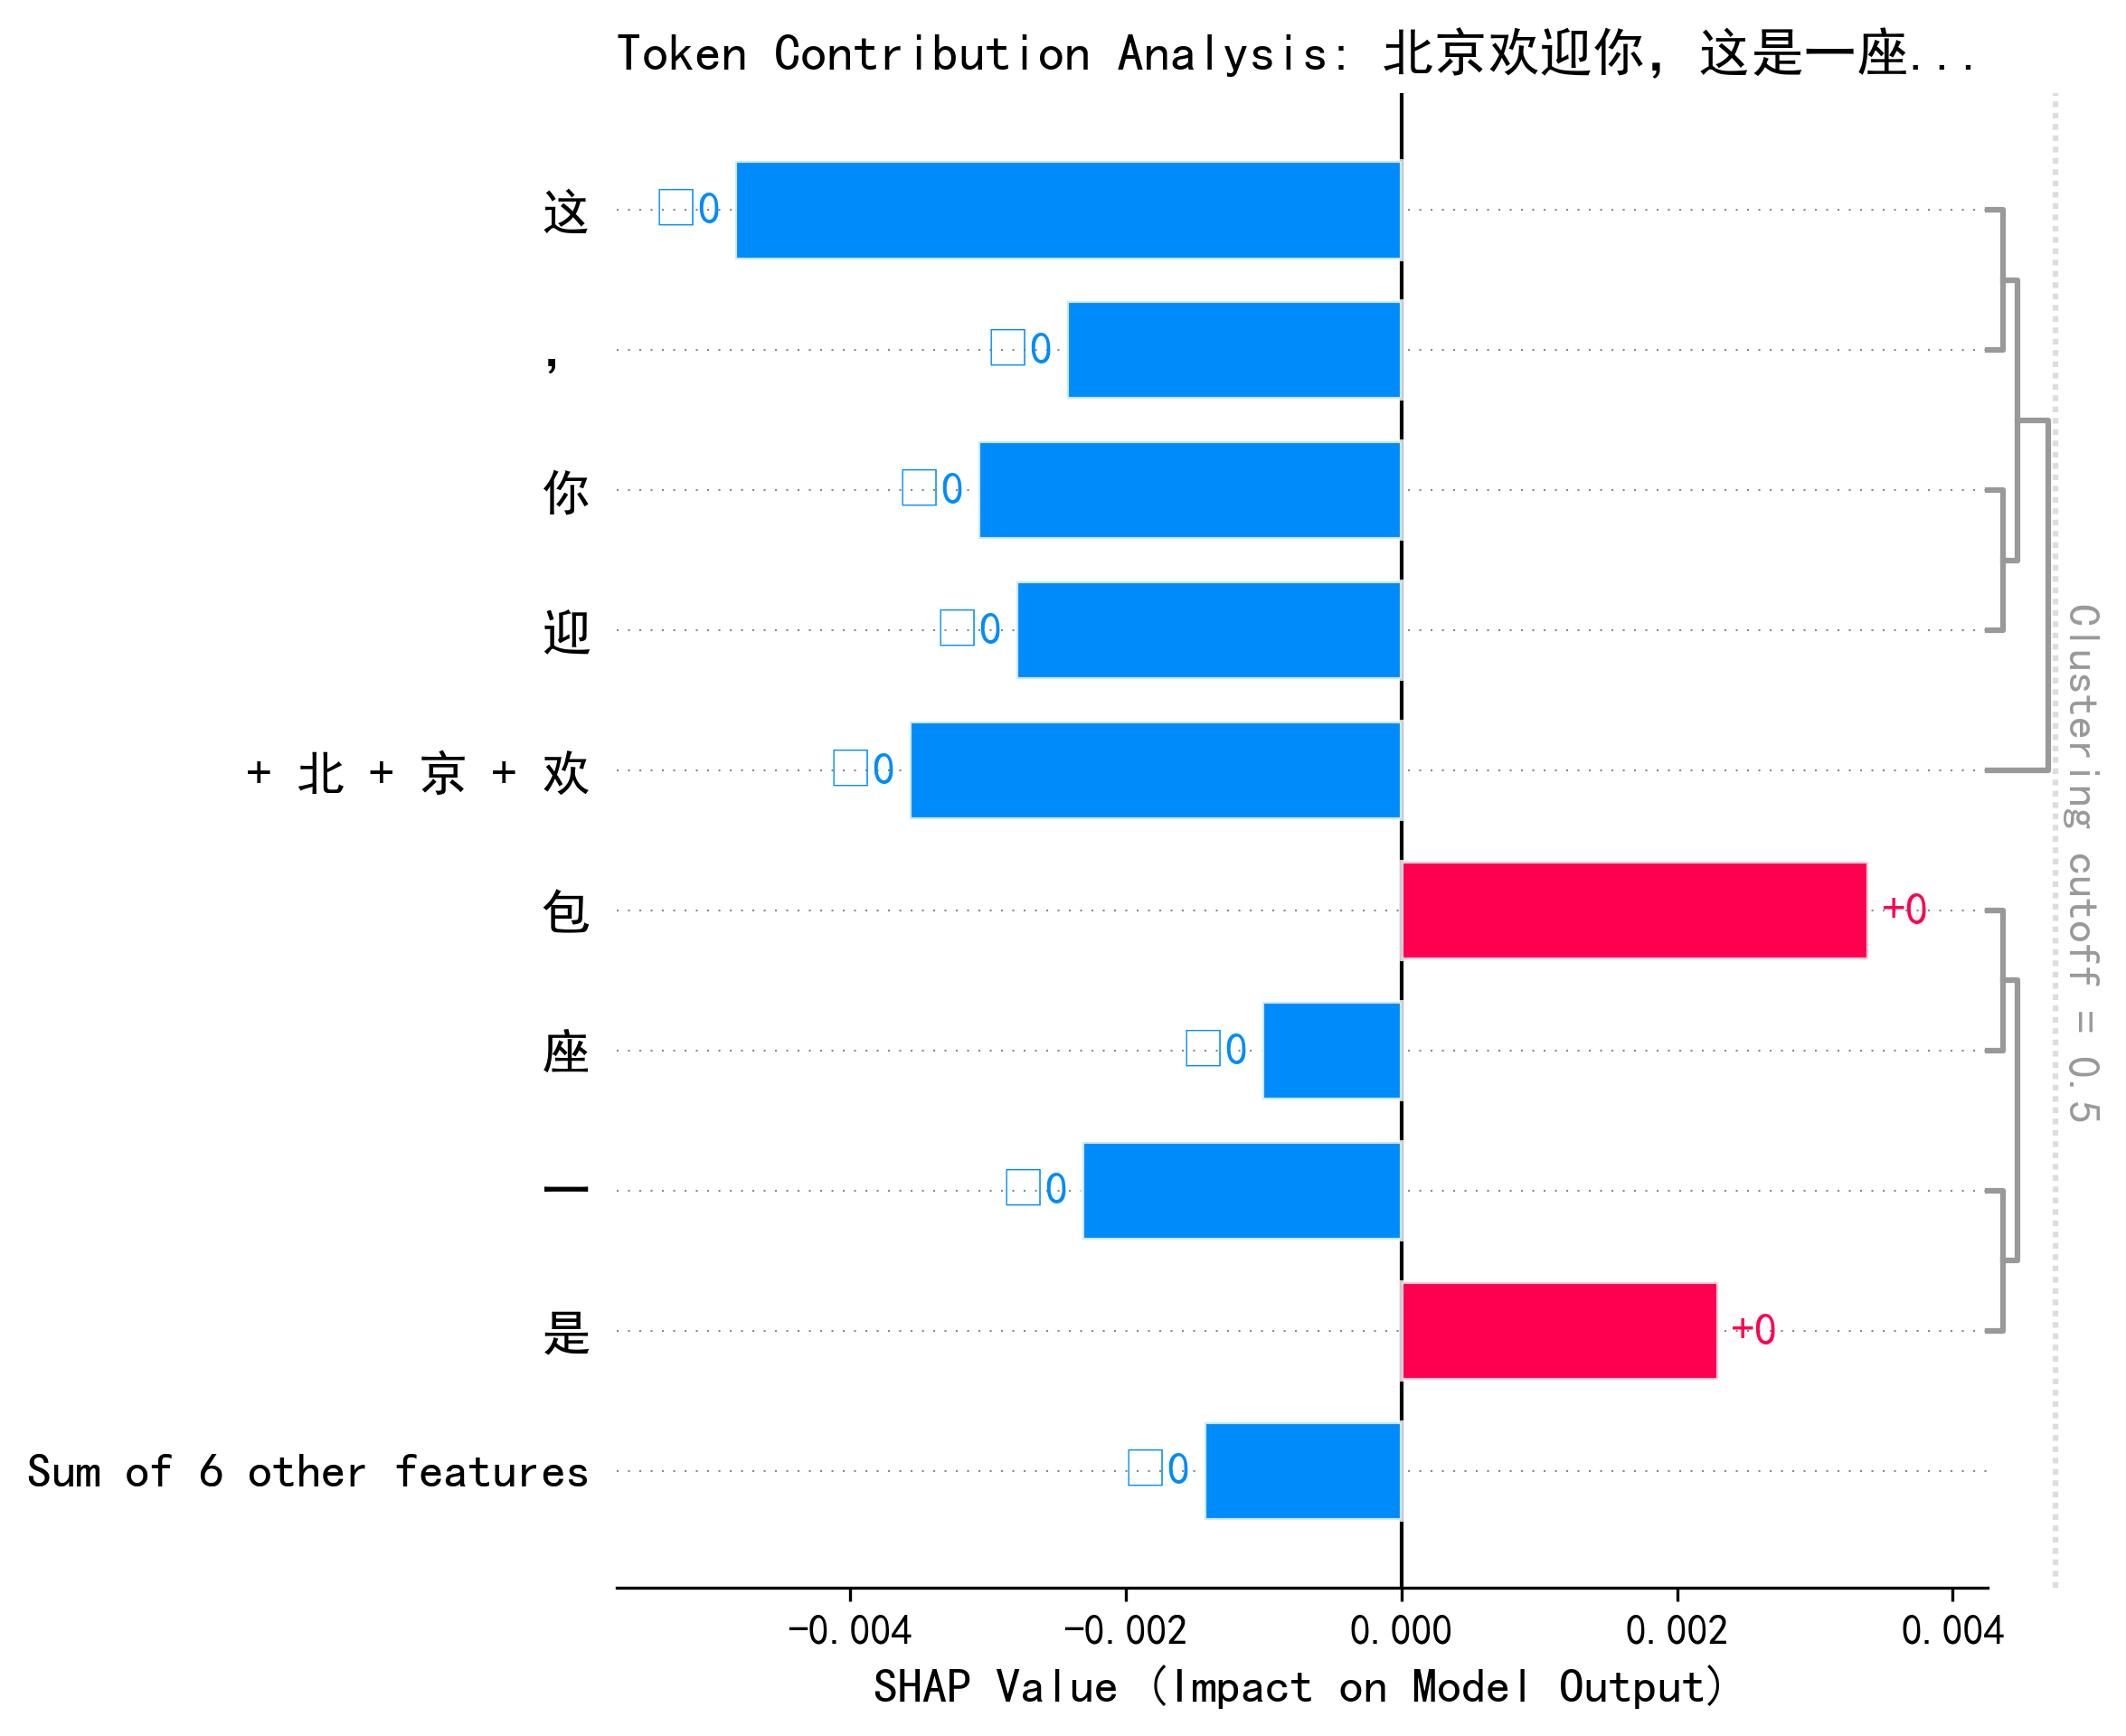

Processing sentence 5: 我们要尊重不同的文化...


C:\Users\10375\AppData\Local\Temp\ipykernel_30124\560176080.py:64: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  plt.tight_layout()
C:\Users\10375\AppData\Local\Temp\ipykernel_30124\560176080.py:68: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  plt.savefig(filename, bbox_inches='tight', dpi=300)


Saved: shap_analysis_cn_4.png


E:\PY\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


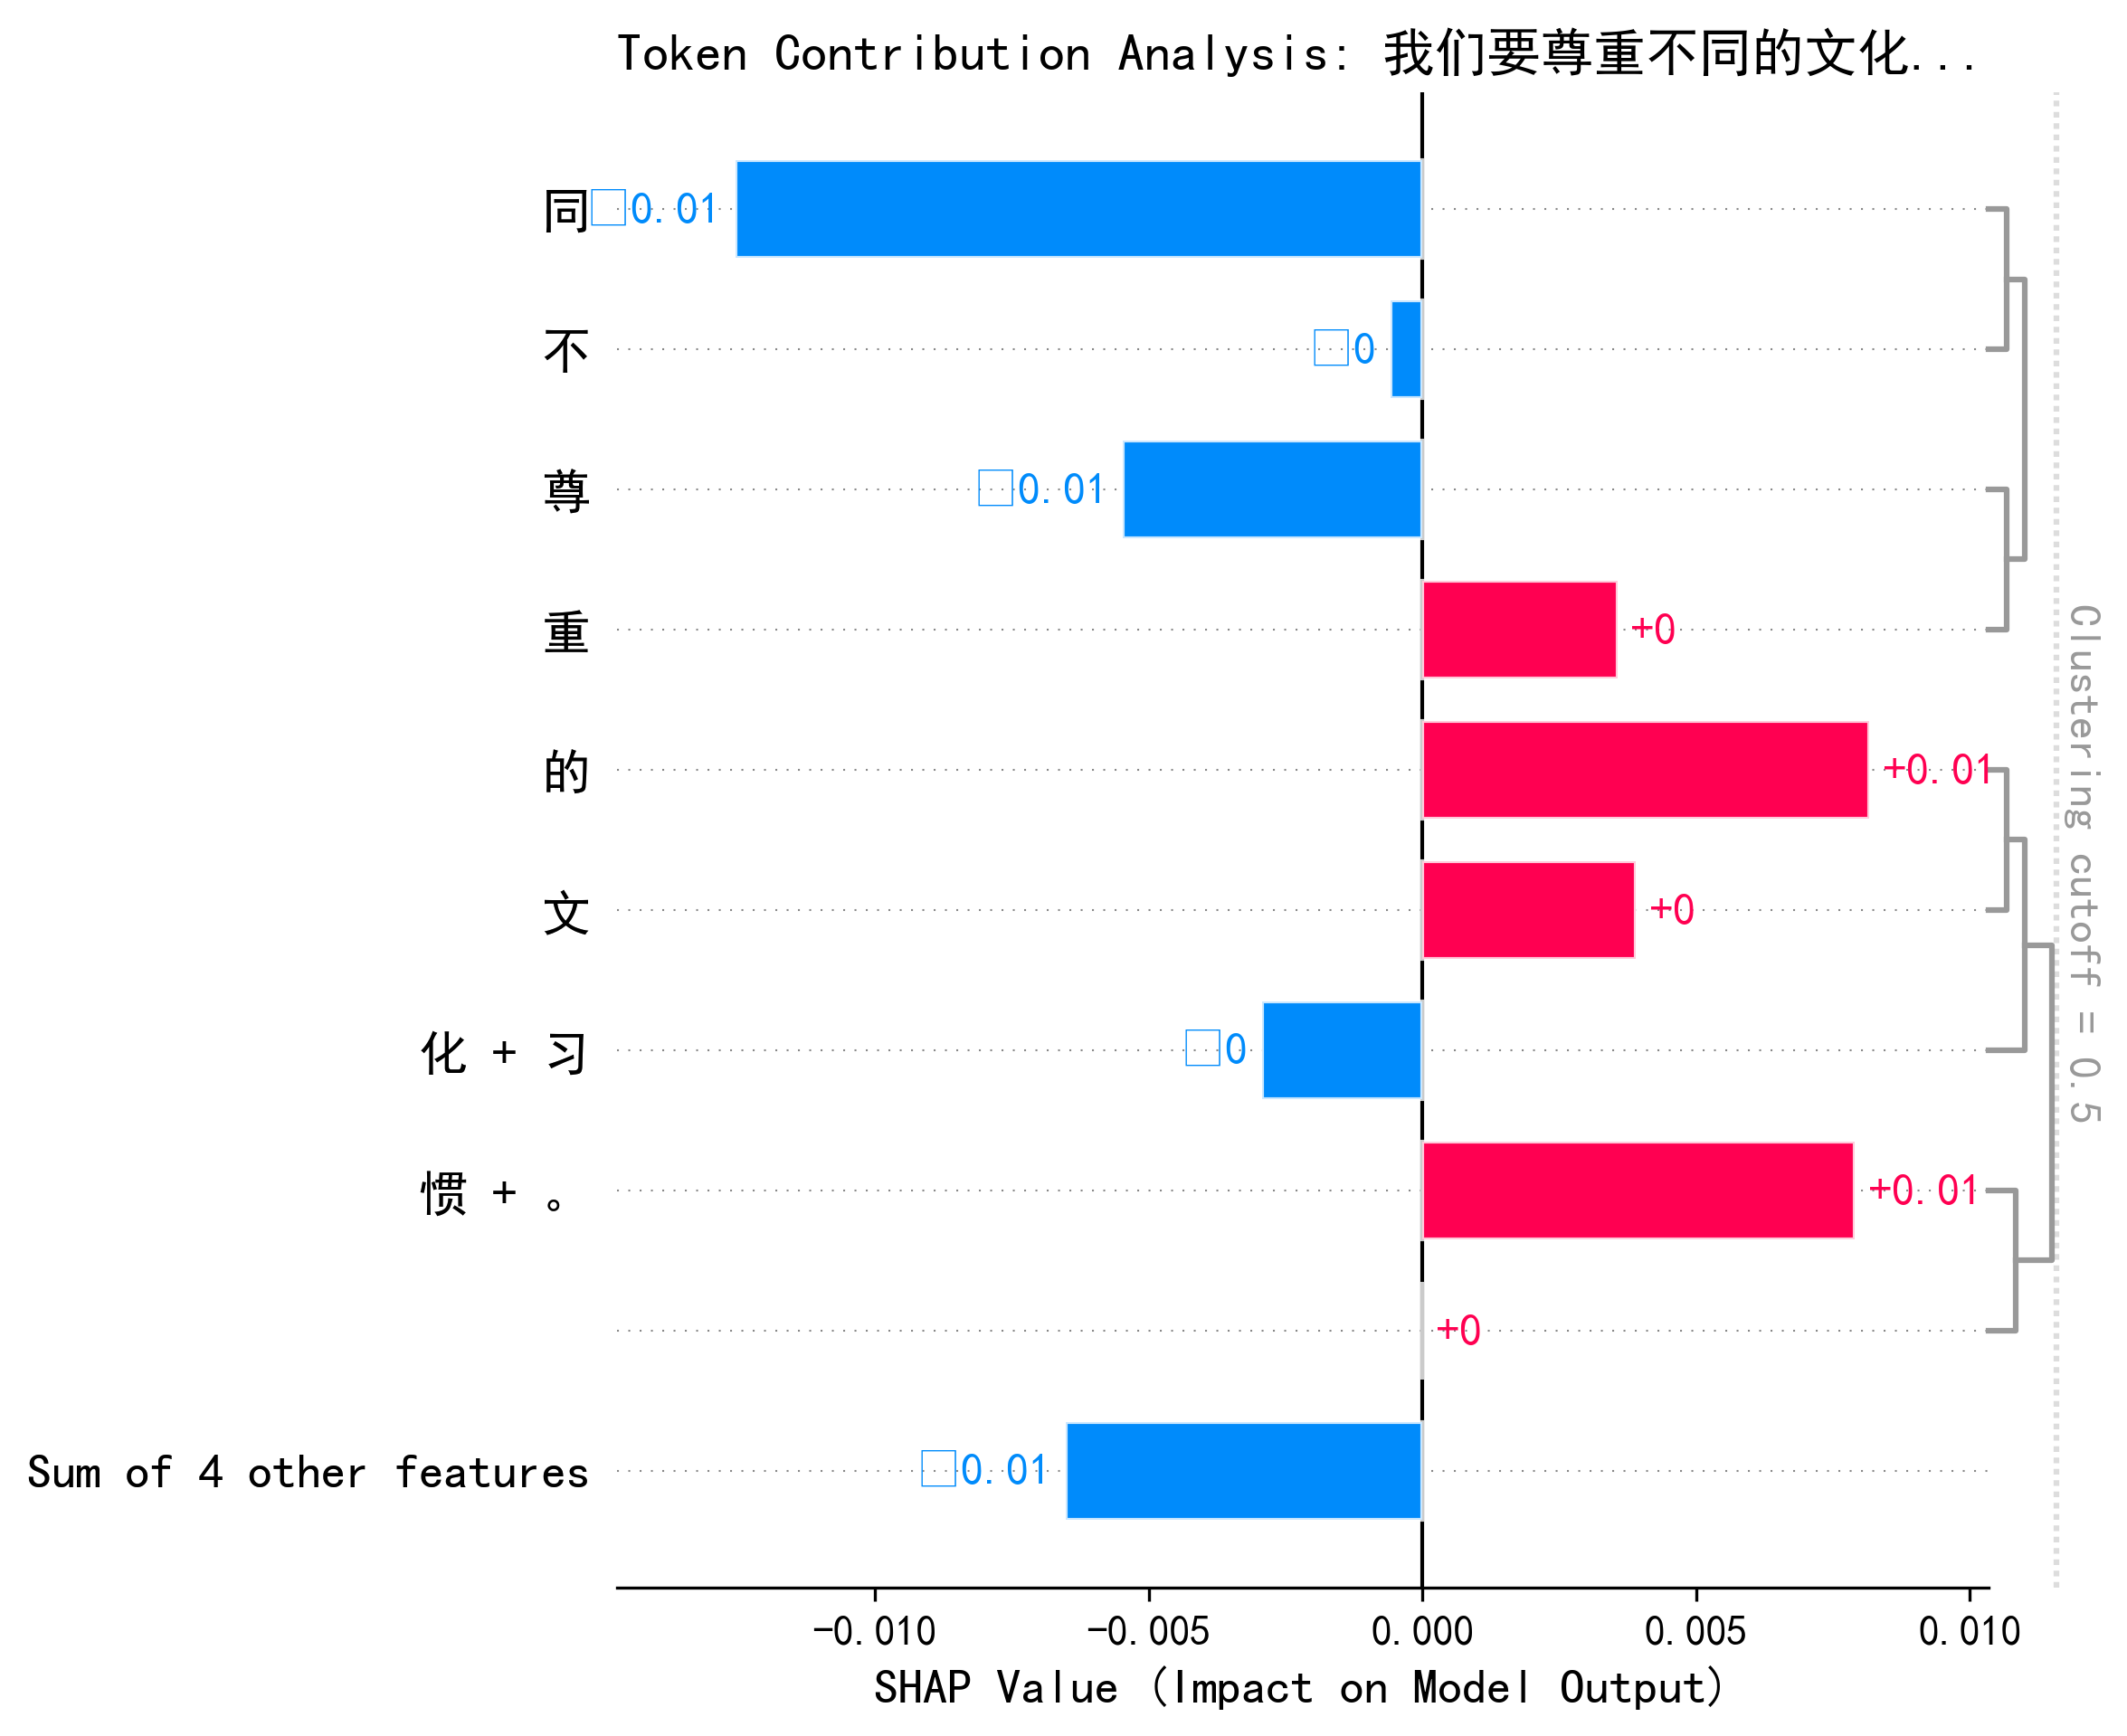

All plots generated successfully.


In [6]:
import matplotlib.pyplot as plt
import shap
import numpy as np

# 1. Initialize Explainer (Ensure it is defined)
# If 'explainer' is not already in memory, uncomment the following line:
# explainer = shap.Explainer(pred_pipeline)

print("Calculating SHAP values for Chinese test sentences...")

# 2. Define Test Sentences (Chinese Context)
test_sentences = [
    "河南人都是骗子，千万别信。",           # Regional stereotype
    "女司机就是马路杀手，技术太差。",       # Gender stereotype
    "黑人智商低，比较懒。",                 # Racial stereotype
    "北京欢迎你，这是一座包容的城市。",     # Neutral (Positive)
    "我们要尊重不同的文化习惯。"             # Neutral
]

# Recalculate SHAP values
shap_values = explainer(test_sentences)

# 3. Configure Fonts for Chinese Character Support
# Attempt to load common Chinese fonts available on various systems
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'Microsoft YaHei', 'Heiti TC', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False

# 4. Generate and Save Bar Plots
# Target label index for "Stereotype" (Assuming index 1 is the positive class)
target_label_idx = 1 

for i, sentence in enumerate(test_sentences):
    # Truncate long sentences for display
    display_sentence = sentence[:10] + "..." if len(sentence) > 10 else sentence
    print(f"Processing sentence {i+1}: {display_sentence}")
    
    # Initialize figure
    plt.figure(figsize=(10, 6), dpi=300)
    
    # Robustly retrieve SHAP values for the target class
    try:
        # Try accessing by index directly
        shap_data = shap_values[i, :, target_label_idx]
    except Exception:
        try:
            # Try accessing by label name if available
            shap_data = shap_values[i, :, "LABEL_1"]
        except Exception:
            # Fallback for single-output models
            shap_data = shap_values[i]

    # Plot the SHAP values using a bar chart
    # show_data=False prevents encoding errors with non-ASCII characters on the y-axis
    shap.plots.bar(
        shap_data, 
        max_display=10, 
        show=False, 
        show_data=False
    )
    
    # Set plot title and layout
    plt.title(f"Token Contribution Analysis: {display_sentence}", fontsize=14)
    plt.xlabel("SHAP Value (Impact on Model Output)")
    plt.tight_layout()
    
    # Save the figure
    filename = f"shap_analysis_cn_{i}.png"
    plt.savefig(filename, bbox_inches='tight', dpi=300)
    print(f"Saved: {filename}")
    
    # Display the plot
    plt.show()

print("All plots generated successfully.")

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import os

# Create assets directory if not exists
if not os.path.exists('assets'):
    os.makedirs('assets')

# 1. Plot Training and Validation Loss
def plot_loss_curves(trainer):
    log_history = trainer.state.log_history
    train_loss = []
    eval_loss = []
    steps = []
    
    for entry in log_history:
        if 'loss' in entry:
            train_loss.append(entry['loss'])
            steps.append(entry['step'])
        if 'eval_loss' in entry:
            # Align eval loss with the last recorded step or its own step
            eval_loss.append(entry['eval_loss'])

    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Training Loss', color='blue')
    # If eval_loss is recorded less frequently, simple plot might mismatch x-axis, 
    # but for simple visualization this is often sufficient.
    if eval_loss:
        plt.plot(eval_loss, label='Validation Loss', color='red')
    
    plt.title('Training and Validation Loss Over Steps')
    plt.xlabel('Logging Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('assets/loss_curve.png', dpi=300)
    plt.show()

# 2. Plot Confusion Matrix
def plot_confusion_matrix(trainer, test_dataset):
    predictions = trainer.predict(test_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    labels = predictions.label_ids
    
    cm = confusion_matrix(labels, preds)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non-Stereotype', 'Stereotype'], 
                yticklabels=['Non-Stereotype', 'Stereotype'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.savefig('assets/confusion_matrix.png', dpi=300)
    plt.show()

# 3. Plot Metrics Bar Chart
def plot_metrics(metrics_dict):
    # Filter out non-metric keys like 'epoch'
    target_metrics = ['eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall']
    names = []
    values = []
    
    for k, v in metrics_dict.items():
        if k in target_metrics:
            names.append(k.replace('eval_', '').capitalize())
            values.append(v)
            
    plt.figure(figsize=(8, 5))
    bars = plt.bar(names, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    plt.ylim(0, 1.1)
    plt.title('Model Performance Metrics')
    plt.ylabel('Score')
    
    # Add numbers on top of bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 4), ha='center', va='bottom')
        
    plt.savefig('assets/metrics_chart.png', dpi=300)
    plt.show()

# Execute plotting functions
print("Generating visualizations...")
plot_loss_curves(trainer)
plot_confusion_matrix(trainer, test_dataset)

# Assuming you have the eval_results dictionary from trainer.evaluate()
eval_results = trainer.evaluate()
plot_metrics(eval_results)

print("Images saved to 'assets/' folder.")

Generating visualizations...


NameError: name 'trainer' is not defined